In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler
from pandas.api.types import is_numeric_dtype
from sklearn.linear_model import LinearRegression
from pprint import pprint
from sklearn.metrics import mean_squared_error


# Deliverables
1. Research Question
    - Can we predict the S&P price over the next 10 days using financial indicators?
3. Hypothesis
    - Null: There are no correlations
    - Alternative: There are correlations

In [2]:
bond_yield_df = pd.read_csv("Bond yield.csv")
cpi_df = pd.read_csv("Consumer price index.csv")
dj_df = pd.read_csv("Dow Jones.csv")
usd_eur_df = pd.read_csv("USD_EUR.csv")
usd_jpy_df = pd.read_csv("USD_JPY.csv")
gdp_df = pd.read_csv("GDP.csv")
national_hpi_df = pd.read_csv("National home price index.csv")
sp_df = pd.read_csv("S&P Price.csv")

dfs = [bond_yield_df, cpi_df, dj_df, usd_eur_df, usd_jpy_df, gdp_df, national_hpi_df, sp_df]

In [3]:
for i in range(len(dfs)):
    dfs[i].columns.values[0] = 'date'
    dfs[i] = dfs[i].drop_duplicates(subset="date", keep="first") 
    
    dfs[i].set_index('date', inplace=True)
    dfs[i].index = pd.to_datetime(dfs[i].index, errors="coerce").normalize()

    dfs[i] = dfs[i][~dfs[i].index.duplicated(keep="first")]
    


In [4]:
merged_df = pd.concat(dfs, axis=1)

In [5]:
df = merged_df[['Value', 'DJIA', 'GDP', 'DGS10', 'CSUSHPINSA', 'CPIAUCSL', 'EURO', 'JPY']]
df.columns = ['SP_price','dow_jones','gdp','bond_yield','home_price_index','consumer_price_index','eur','jpy']
for col in df.columns:
    print(col)
    # df[col] = pd.to_numeric(df[col])
df.reset_index(inplace=True)
full_date_range = pd.date_range(start=df['date'].min(), end=df['date'].max(), freq='D')
df.set_index("date", inplace=True) 
df = df.reindex(full_date_range)
df.index.name = "date"

df= df.ffill()

df = df[df.index >= '1987-01-01']


SP_price
dow_jones
gdp
bond_yield
home_price_index
consumer_price_index
eur
jpy


In [6]:
def insert_mirrored_rows(df, num_rows=30):
    """
    Insert chronologically mirrored data point at head and tail of df
    """
    df = df.copy()
    mirrored_rows_head = df.iloc[:num_rows].copy()
    mirrored_rows_head = mirrored_rows_head.iloc[::-1].reset_index(drop=True)

    mirrored_rows_tail = df.iloc[-num_rows:].copy()
    mirrored_rows_tail = mirrored_rows_tail.iloc[::-1].reset_index(drop=True)

    df_extended = pd.concat([mirrored_rows_head, df, mirrored_rows_tail], ignore_index=True)
    
    return df_extended

In [7]:
df['SP_price_ln'] = np.log(df['SP_price'])
df['dow_jones'] = pd.to_numeric(df['dow_jones'].str.replace(',', '', regex=True))

extended_df = insert_mirrored_rows(df['SP_price'].copy(), 200)
df.dtypes

SP_price                float64
dow_jones               float64
gdp                     float64
bond_yield              float64
home_price_index        float64
consumer_price_index    float64
eur                     float64
jpy                     float64
SP_price_ln             float64
dtype: object

In [8]:
ma30_df = df.rolling(window=30).mean().reset_index().iloc[30:-30].reset_index(drop=True)
ma100_df = df.rolling(window=100).mean().reset_index().iloc[100:-100].reset_index(drop=True)
ma200_df = df.rolling(window=200).mean().reset_index().iloc[200:-200].reset_index(drop=True)
df['SP_MA_30'] = df['SP_price'].rolling(window=30).mean()
df['SP_MA_100'] = df['SP_price'].rolling(window=100).mean()
df['SP_MA_200'] = df['SP_price'].rolling(window=200).mean()


In [9]:

df.reset_index(inplace=True)  # Move the index back to a column
df.head(500)


,date,SP_price,dow_jones,gdp,bond_yield,home_price_index,consumer_price_index,eur,jpy,SP_price_ln,SP_MA_30,SP_MA_100,SP_MA_200
0,1987-01-01,242.712498,1895.95,4722.156,7.23,63.733,111.4,0.9107,157.47,5.491878,NaN,NaN,NaN
1,1987-01-02,244.309998,1927.31,4722.156,7.18,63.733,111.4,0.9084,158.02,5.498438,NaN,NaN,NaN
2,1987-01-03,244.309998,1927.31,4722.156,7.18,63.733,111.4,0.9084,158.02,5.498438,NaN,NaN,NaN
3,1987-01-04,244.309998,1927.31,4722.156,7.18,63.733,111.4,0.9084,158.02,5.498438,NaN,NaN,NaN
4,1987-01-05,249.415001,1971.32,4722.156,7.08,63.733,111.4,0.9149,159.13,5.519118,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1988-05-10,257.094994,2003.65,5190.036,9.07,70.408,117.5,0.8052,124.34,5.549446,261.099916,261.685500,253.366000
496,1988-05-11,255.212502,1965.85,5190.036,9.05,70.408,117.5,0.8054,124.46,5.542097,260.618583,261.674400,253.404600
497,1988-05-12,253.837502,1968.00,5190.036,9.04,70.408,117.5,0.8066,124.46,5.536694,260.055167,261.664025,253.436325
498,1988-05-13,255.334999,1990.55,5190.036,9.00,70.408,117.5,0.8072,124.73,5.542576,259.534333,261.679100,253.523812


In [10]:
df_first_of_month = df[df['date'].dt.day == 1]

## Add timeseries features
- For each daily feature, get the last 10 days for that feature

In [11]:
df['dow_jones_ln'] = np.log(df['dow_jones'])
df['gdp_ln'] = np.log(df['gdp'])
df['home_price_index_ln'] = np.log(df['home_price_index'])
df['bond_yield_ln'] = np.log(df['bond_yield'])


In [12]:
daily_features = ["SP_price_ln", "dow_jones_ln", "gdp_ln", "eur", "jpy", "home_price_index_ln", "consumer_price_index", "bond_yield_ln"]

#################
lookback = 14
forecast = 7
#################

for f in daily_features:
    df[f + f"+{forecast}"] = df[f].shift(-forecast)
for f in daily_features:
    for i in range(1,lookback+1):
        df[f + f"-{i}"] = df[f].shift(i)
# df.iloc[35177:35187]
df_with_wknd = df.copy()
df = df[df['date'].dt.weekday < 5].reset_index(drop=True)

df.shape

C:\Users\wachic\AppData\Local\Temp\ipykernel_20320\1865863209.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f + f"-{i}"] = df[f].shift(i)
C:\Users\wachic\AppData\Local\Temp\ipykernel_20320\1865863209.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f + f"-{i}"] = df[f].shift(i)
C:\Users\wachic\AppData\Local\Temp\ipykernel_20320\1865863209.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all c

(10002, 137)

In [13]:
i = 1
for col in df.columns:
    print(f'{i}: {col}')
    i+=1

1: date
2: SP_price
3: dow_jones
4: gdp
5: bond_yield
6: home_price_index
7: consumer_price_index
8: eur
9: jpy
10: SP_price_ln
11: SP_MA_30
12: SP_MA_100
13: SP_MA_200
14: dow_jones_ln
15: gdp_ln
16: home_price_index_ln
17: bond_yield_ln
18: SP_price_ln+7
19: dow_jones_ln+7
20: gdp_ln+7
21: eur+7
22: jpy+7
23: home_price_index_ln+7
24: consumer_price_index+7
25: bond_yield_ln+7
26: SP_price_ln-1
27: SP_price_ln-2
28: SP_price_ln-3
29: SP_price_ln-4
30: SP_price_ln-5
31: SP_price_ln-6
32: SP_price_ln-7
33: SP_price_ln-8
34: SP_price_ln-9
35: SP_price_ln-10
36: SP_price_ln-11
37: SP_price_ln-12
38: SP_price_ln-13
39: SP_price_ln-14
40: dow_jones_ln-1
41: dow_jones_ln-2
42: dow_jones_ln-3
43: dow_jones_ln-4
44: dow_jones_ln-5
45: dow_jones_ln-6
46: dow_jones_ln-7
47: dow_jones_ln-8
48: dow_jones_ln-9
49: dow_jones_ln-10
50: dow_jones_ln-11
51: dow_jones_ln-12
52: dow_jones_ln-13
53: dow_jones_ln-14
54: gdp_ln-1
55: gdp_ln-2
56: gdp_ln-3
57: gdp_ln-4
58: gdp_ln-5
59: gdp_ln-6
60: gdp_ln-7

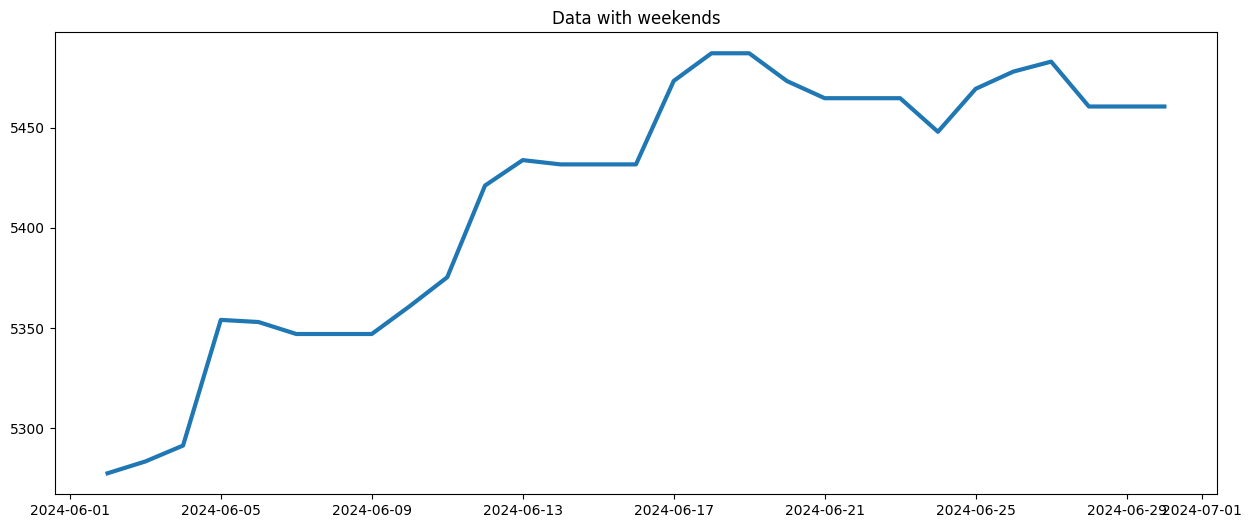

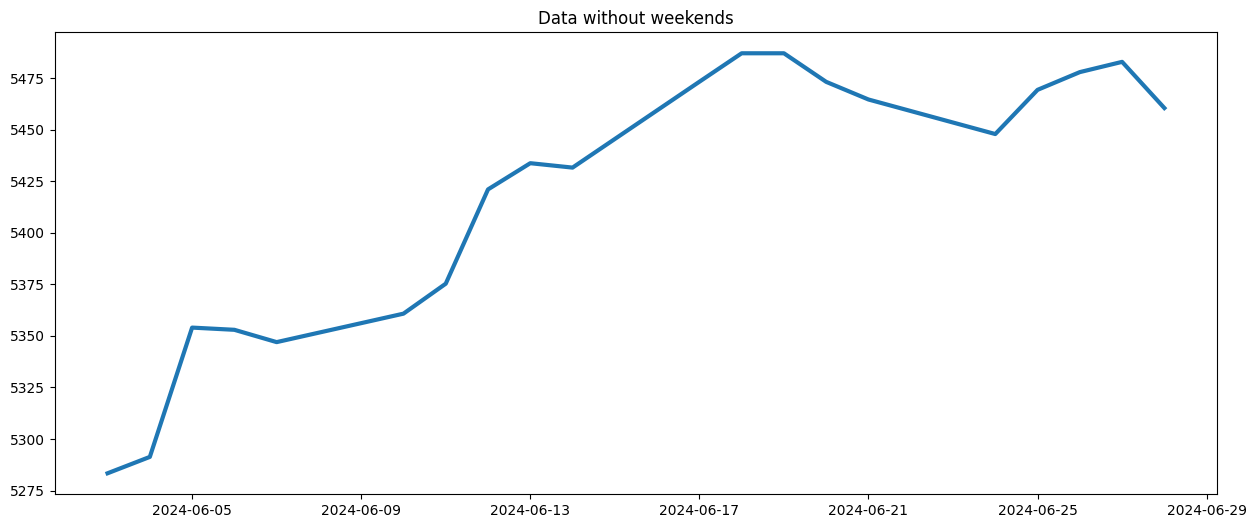

In [29]:
start, end = ('2024-6-1','2024-7-1')
df_with_wknd_event = df_with_wknd[(df_with_wknd['date'] > pd.to_datetime(start)) & (df_with_wknd['date'] < pd.to_datetime(end))]
df_event = df[(df['date'] > pd.to_datetime(start)) & (df['date'] < pd.to_datetime(end))]

plt.figure(figsize = (15,6))
plt.plot(df_with_wknd_event['date'],df_with_wknd_event['SP_price'], linewidth=3)
plt.title('Data with weekends')
plt.show()
plt.figure(figsize = (15,6))
plt.plot(df_event['date'],df_event['SP_price'], linewidth=3)
plt.title('Data without weekends')
plt.show()

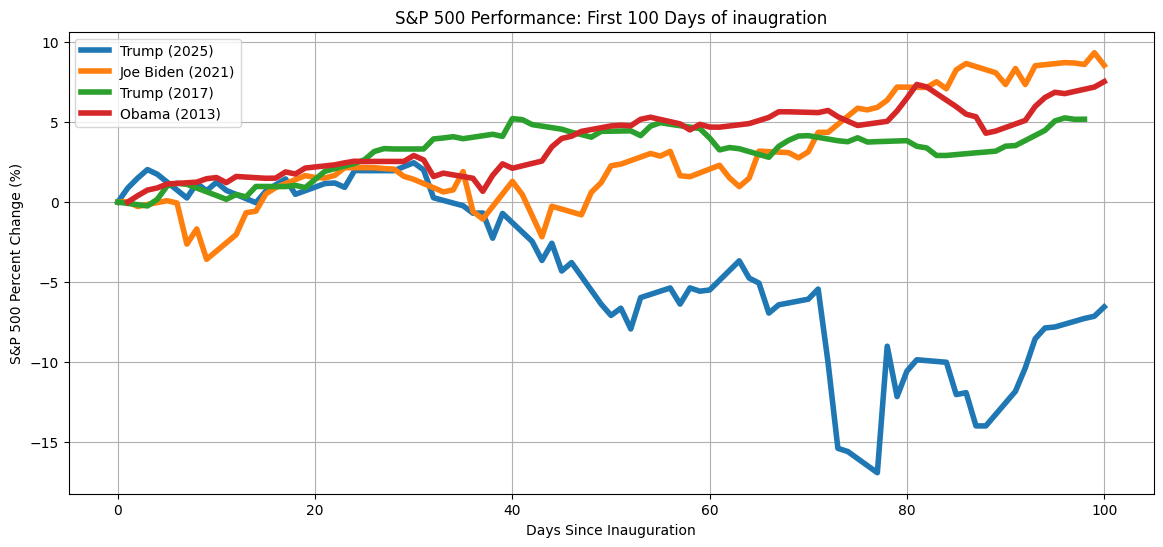

In [15]:
inaugurations = {
    'Trump (2025)': pd.Timestamp('2025-01-20'), 
    'Joe Biden (2021)': pd.Timestamp('2021-01-20'),
    'Trump (2017)': pd.Timestamp('2017-01-20'),
    'Obama (2013)': pd.Timestamp('2013-01-20')
}

plt.figure(figsize=(14, 6))
for president, start_date in inaugurations.items():
    end_date = start_date + pd.DateOffset(days=100)
    
    mask = (df['date'] >= start_date) & (df['date'] <= end_date)
    period_df = df.loc[mask].copy()
    
    if not period_df.empty:
        period_df['Days Since Inauguration'] = (period_df['date'] - start_date).dt.days
        
        start_price = period_df.iloc[0]['SP_price']
        
        period_df['Percent Change'] = ((period_df['SP_price'] - start_price) / start_price) * 100
        
        plt.plot(
            period_df['Days Since Inauguration'],
            period_df['Percent Change'],
            label=president,
            linewidth=4
        )
plt.xlabel('Days Since Inauguration')
plt.ylabel('S&P 500 Percent Change (%)')
plt.title('S&P 500 Performance: First 100 Days of inaugration')
plt.grid(True)
plt.legend()
plt.show()


Intercept: -0.46536737443949594
Coefficients: [ 5.02930647e-01  6.60722941e-02  2.90171640e-01 -1.47150120e-02
  1.36531984e-01 -8.46569947e-02 -4.89292331e-02  2.37681447e-01
 -1.28779254e-01  6.57514469e-02  1.15130426e-01 -5.95229784e-02
 -5.03840145e-02  8.37790235e-01 -2.26138472e-01 -2.33166971e-01
 -1.62789528e-01 -6.91808301e-02 -4.74313390e-02 -5.45652039e-02
  6.33684316e-02 -7.11208108e-02 -1.35614642e-02 -6.43149372e-04
 -1.84011747e-01  8.74896448e-02  3.27021032e-02 -1.44653961e-01
  8.36600556e-02  3.30819357e-01 -1.76007621e-01 -3.27335583e-01
  2.34065601e-02  2.06699401e-01  1.81143587e-01 -2.95650063e-02
 -1.19638896e-01 -4.66816940e-01  1.59315373e-01  1.83233637e-01
  1.91984477e-01 -1.55747742e-01 -2.85153624e-02  1.49973286e-01
  9.43451585e-02 -4.60704693e-02  6.42574643e-03  8.09757943e-02
 -5.47623099e-02  3.51491643e-02  3.23668028e-03 -5.47295923e-02
  4.70767093e-02  3.98633651e-02 -1.32351550e-01 -1.65913807e-05
  7.14673152e-05 -8.88690025e-04  1.11834848

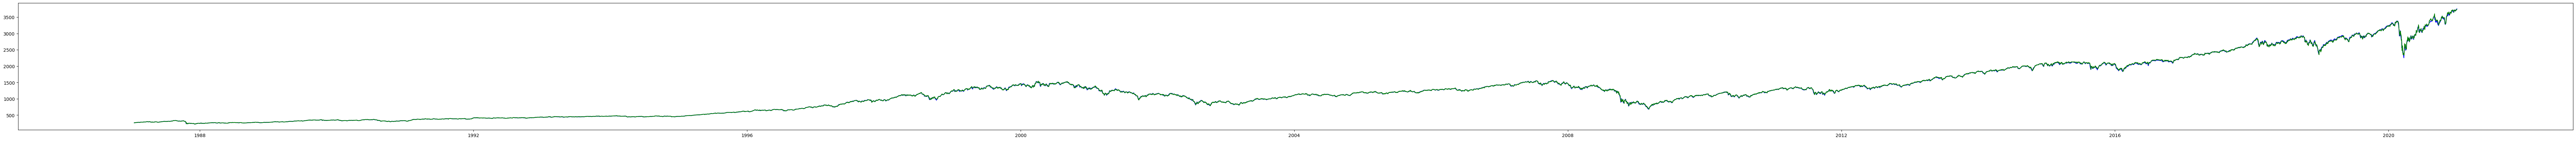

In [16]:
df_filtered = df[(df['date'].dt.year >= 1980) & (df['date'].dt.year <= 2020)]
col =  df.iloc[:, 26:].columns
df_filtered = df_filtered.dropna(subset=col)

X = df_filtered[col]
y = df_filtered[f'SP_price_ln+{forecast}']

model = LinearRegression()
model.fit(X, y)

print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)

# Predict on new data
predictions = model.predict(X)

plt.figure(figsize=(100, 5))
plt.plot(df_filtered['date'], df_filtered['SP_price'], linestyle='-', color='b', markersize=6, label="data")
plt.plot(df_filtered['date'], math.e**predictions, linestyle='-', color='g', markersize=6, label="data")
plt.show()

In [17]:
X_new = df[df['date'] == '2020-12-31'][col]

# Make the prediction
predicted_ln = model.predict(X_new)

# Convert the log prediction back to the actual price
predicted_price = np.exp(predicted_ln)

# Print the predicted price
print(f"Predicted S&P price for 2021-01-10: {predicted_price[0]:.2f}")

value = df[df['date'] == '2020-12-31']['SP_price'].values[0]
print(f"Actual S&P price for 2021-01-10: {value}")


Predicted S&P price for 2021-01-10: 3738.06
Actual S&P price for 2021-01-10: 3756.07


In [18]:
refined = []
for i in range(len(col)):
    if model.coef_[i] > 0.02:
        refined.append(col[i])

Intercept: 0.05826157833514234
Coefficients: [ 0.46641632 -0.20617723  0.15260792  0.15586423  0.19929303 -0.1002905
  0.34038924  0.56402236 -0.27442724 -0.25463807 -0.04715923 -0.02508433
  0.06154457 -0.26493777  0.08225582  0.141656   -0.20841125  0.21414271
  0.00349217 -0.07562127  0.07200659  0.02677142  0.05112723 -0.00831228
 -0.07498674  0.23377025 -0.14301851  0.16766686  0.07957456 -0.13969603
 -0.16200182 -0.04227448  0.00158252 -0.00230925 -0.00578509]


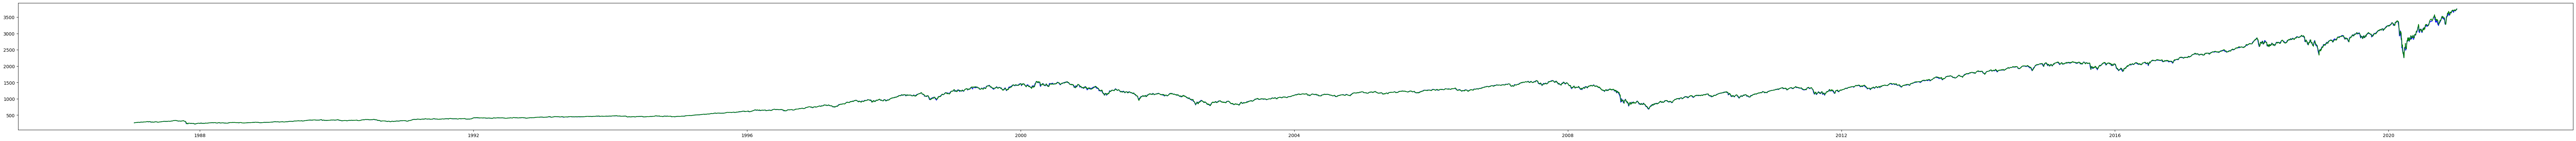

In [19]:
col =  refined
X = df_filtered[col]
y = df_filtered[f'SP_price_ln+{forecast}']

model = LinearRegression()
model.fit(X, y)

print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)

# Predict on new data
predictions2 = model.predict(X)

plt.figure(figsize=(100, 5))
plt.plot(df_filtered['date'], df_filtered['SP_price'], linestyle='-', color='b', markersize=6, label="data")
plt.plot(df_filtered['date'], math.e**predictions2, linestyle='-', color='g', markersize=6, label="data")
plt.show()

In [20]:
X_new = df[df['date'] == '2020-12-31'][col]

# Make the prediction
predicted_ln = model.predict(X_new)

# Convert the log prediction back to the actual price
predicted_price = np.exp(predicted_ln)

# Print the predicted price
print(f"Predicted S&P price for 2021-01-10: {predicted_price[0]:.2f}")

value = df[df['date'] == '2020-12-31']['SP_price'].values[0]
print(f"Actual S&P price for 2021-01-10: {value}")


Predicted S&P price for 2021-01-10: 3746.90
Actual S&P price for 2021-01-10: 3756.07


In [21]:
df_model3 = df[(df['date'].dt.year >= 1980) & (df['date'].dt.year <= 2020)]
normalized = df_model3.copy()
scaler = StandardScaler()
y_col = "SP_price_ln"
features = normalized.drop(columns=["date",y_col,"SP_price"] + list(filter(lambda x: '+' in x, normalized.columns)))
y=df_model3[y_col]
scaled_array = scaler.fit_transform(features)
normalized = pd.DataFrame(scaled_array, index=features.index, columns=features.columns)
normalized[y_col] = y

n = len(normalized)
def adj_r2(R2, p):
    """Adjusted r^2 score from R^2, and number of features"""
    return 1-(1-R2)*(n-1)/(n-p-1)

# Model 3 (using greedy algorithm)
mod_3_scores = []
for c in normalized.columns:
    if c == y_col: continue
    model = LinearRegression(fit_intercept=True)
    
    working_df = normalized.dropna(subset=[y_col,c])
    col = working_df[c].to_numpy().reshape(-1,1)
    model.fit(col,working_df[y_col])
    score = adj_r2(model.score(col,working_df[y_col]),1)
    mod_3_scores.append((c,score))

mod_3_scores = sorted(mod_3_scores, key=lambda x: x[1],reverse=True)
print("Sorted scores for individual linear regressions:")
pprint(mod_3_scores)
print()

mod_3_score = 0
mod_3_cols = []
reg3 = LinearRegression(fit_intercept=True)
for c,_ in mod_3_scores:
    working_df = normalized.dropna(subset=mod_3_cols+[c,y_col])
    X = working_df[mod_3_cols + [c]]
    reg3.fit(X,working_df[y_col])
    score = adj_r2(reg3.score(X,working_df[y_col]),len(mod_3_cols) + 1)
    if score > mod_3_score:
        mod_3_score = score
        mod_3_cols += [c]

final_scaler = StandardScaler()

working_df = df_model3.dropna(subset=mod_3_cols + [y_col])
X3_raw = working_df[mod_3_cols]
X3_scaled = pd.DataFrame(final_scaler.fit_transform(X3_raw), columns=mod_3_cols)

reg3.fit(X3_scaled, working_df[y_col])
trained_features = mod_3_cols.copy()



Sorted scores for individual linear regressions:
[('SP_price_ln-1', 0.9998553232307024),
 ('SP_price_ln-2', 0.9996572172456778),
 ('SP_price_ln-3', 0.9995208354304488),
 ('SP_price_ln-4', 0.9993844228167917),
 ('SP_price_ln-5', 0.9992379161819903),
 ('SP_price_ln-6', 0.9991051077150463),
 ('SP_price_ln-7', 0.9989392728960982),
 ('SP_price_ln-8', 0.9987276023060145),
 ('SP_price_ln-9', 0.9985620253360292),
 ('SP_price_ln-10', 0.9984522905292689),
 ('SP_price_ln-11', 0.9983484304336137),
 ('SP_price_ln-12', 0.9982146931819181),
 ('SP_price_ln-13', 0.9980792120272761),
 ('SP_price_ln-14', 0.9979101872471715),
 ('dow_jones_ln', 0.9931667451377448),
 ('dow_jones_ln-1', 0.9931113298147601),
 ('dow_jones_ln-2', 0.9928853049404394),
 ('dow_jones_ln-3', 0.9927302310609102),
 ('dow_jones_ln-4', 0.9925856262589987),
 ('dow_jones_ln-5', 0.992422888468211),
 ('dow_jones_ln-6', 0.9922952921157933),
 ('dow_jones_ln-7', 0.9921374748444205),
 ('dow_jones_ln-8', 0.991905363209072),
 ('dow_jones_ln-9', 0

In [22]:
X_filtered = df[df['date'] == '2020-12-31']
X_new_raw = X_filtered[trained_features].copy()

# Fill missing columns if needed
for col in trained_features:
    if col not in X_new_raw.columns:
        X_new_raw[col] = np.nan  # or 0

X_new_scaled = pd.DataFrame(final_scaler.transform(X_new_raw), columns=trained_features)

predicted_ln = reg3.predict(X_new_scaled)
predicted_price = np.exp(predicted_ln)

print(f"Predicted S&P ln price for 2021-01-10: {predicted_ln[0]:.2f}")
print(f"Predicted S&P price for 2021-01-10: {predicted_price[0]:.2f}")

value = df[df['date'] == '2020-12-31']['SP_price'].values[0]
print(f"Actual S&P price for 2021-01-10: {value}")

print("Coefficients:", reg3.coef_)
print("Intercept:", reg3.intercept_)
print("Input features:", X_new)


Predicted S&P ln price for 2021-01-10: 8.23
Predicted S&P price for 2021-01-10: 3750.96
Actual S&P price for 2021-01-10: 3756.07
Coefficients: [ 6.29813749e-01 -1.07643710e-01  1.09200682e-01  1.90705217e-02
  3.77787890e-02  3.74611088e-01 -1.06270303e-02 -2.38252494e-01
  3.68035885e-02 -1.03946884e-01 -2.50394916e-02 -2.07576476e-02
 -6.70078297e-03 -2.88049392e-03  4.60844890e-04  3.08160019e-02
 -4.11863971e-02  9.61834267e-03 -7.13830411e-03 -2.60870626e-03
  9.51429823e-03  6.08076369e-05  4.02577257e-04  3.43962600e-03
 -1.38977680e-02  1.60781032e-02 -1.05449463e-02  1.86940138e-03
  3.94222771e-03 -5.11130036e-03  1.42394767e-02 -2.53080401e-02
  1.46082591e-02 -1.68283278e-03  1.55124302e-03]
Intercept: 6.908020033614518
Input features:       SP_price_ln-2  SP_price_ln-3  SP_price_ln-4  SP_price_ln-6  \
8870        8.22337       8.225599       8.216915       8.216915   

      SP_price_ln-9  SP_price_ln-11  SP_price_ln-12  dow_jones_ln-1  \
8870       8.212639        8.21862

In [23]:
# change window size here
#############
lookback = lookback
forecast_horizon = forecast
##############


feature_cols = df.iloc[:, 26:].columns

df_model = df.iloc[lookback:12054, 26:].copy()
df_model['date'] = df.iloc[lookback:12054, 0].values

target_cols = []
for step in range(1, forecast_horizon + 1):
    col_name = f'target_day_{step}'
    df_model[col_name] = df['SP_price_ln'].shift(-step + 1)
    target_cols.append(col_name)

df_model = df_model.dropna(subset=target_cols)

X = df_model[feature_cols].values
Y = df_model[target_cols].values  # shape: (n_samples, 5)

split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
Y_train, Y_test = Y[:split_idx], Y[split_idx:]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LinearRegression().fit(X_train_scaled, Y_train)

Y_pred = model.predict(X_test_scaled)

for i in range(forecast_horizon):
    mse = mean_squared_error(Y_test[:, i], Y_pred[:, i])
    print(f"Test MSE for day {i + 1}: {mse:.4f}")



Test MSE for day 1: 0.0002
Test MSE for day 2: 0.0004
Test MSE for day 3: 0.0008
Test MSE for day 4: 0.0012
Test MSE for day 5: 0.0016
Test MSE for day 6: 0.0022
Test MSE for day 7: 0.0027


In [24]:
# predicts future 5 days using past 10 days.
def test_predictions_leading_up(selected_date, forecast_=5, window=30):

    selected_date = pd.to_datetime(selected_date)
    
    selected_idx = df[df['date'] == selected_date].index[0]
    
    feature_values = df.iloc[selected_idx, 26:].values.reshape(1, -1)
    feature_scaled = scaler.transform(feature_values)
    
    predicted_values = model.predict(feature_scaled)[0]
    
    prediction_date_indices = [selected_idx + i for i in range(1, forecast_ + 1)]
    valid_indices = [idx for idx in prediction_date_indices if idx < len(df)]
    predicted_dates = df['date'].iloc[valid_indices]
    predicted_prices = np.exp(predicted_values[:len(valid_indices)])
    
    plot_start = max(0, selected_idx - window)
    plot_end = min(len(df), selected_idx + forecast_ + window)
    
    plt.figure(figsize=(16, 6))
    
    plt.plot(df['date'].iloc[plot_start:plot_end], df['SP_price'].iloc[plot_start:plot_end], label='Actual S&P 500', color='blue')
    # plt.plot(df['date'].iloc[plot_start:plot_end], df['bond_yield_ln'].iloc[plot_start:plot_end]*3200, label='Actual S&P 500', color='g')
    # plt.plot(df['date'].iloc[plot_start:plot_end], df['consumer_price_index'].iloc[plot_start:plot_end]*10, label='Actual S&P 500', color='r')
    
    plt.plot(predicted_dates, predicted_prices, 'ro--', label=f'Predicted price (next 5days)')
    
    plt.axvline(x=selected_date, color='green', linestyle=':', label=f'Selected Date: {selected_date.date()}')
    
    plt.title(f"{lookback} days to predict {forecast} days in future: {selected_date.date()}")
    plt.xlabel('Date')
    plt.ylabel('S&P 500 Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()


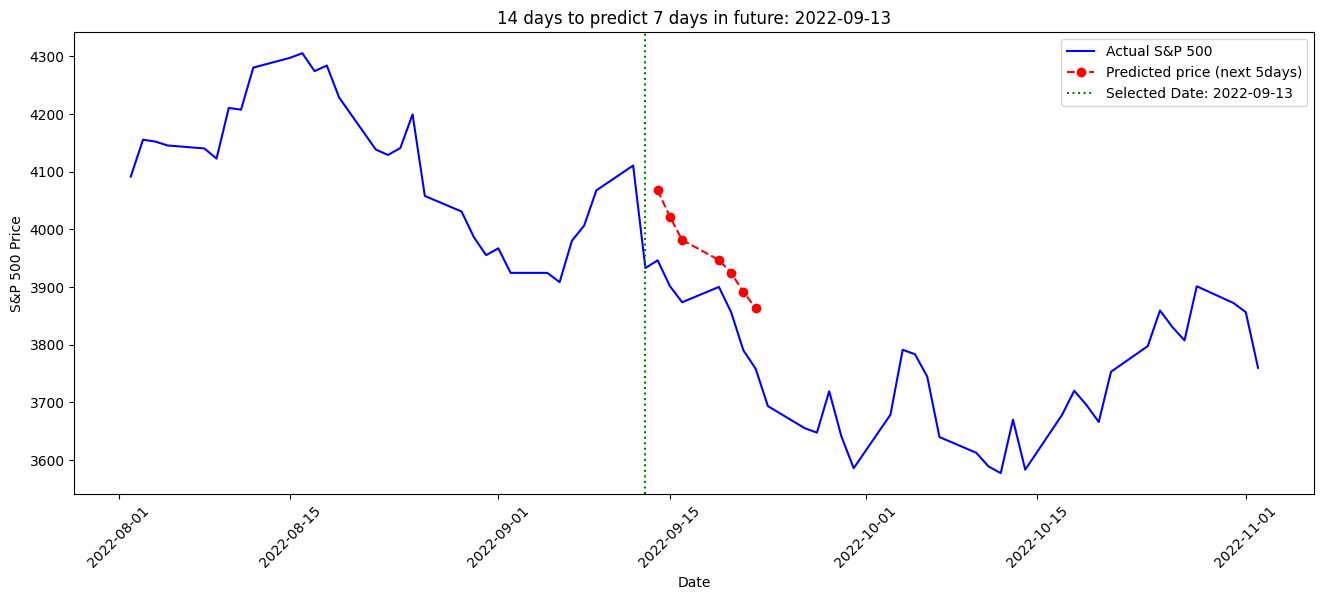

In [25]:
test_predictions_leading_up('2022-9-13', forecast_horizon)

In [26]:
df.to_csv('dfff.csv',index=False)